In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import random
import numpy as np
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from netCDF4 import Dataset

batch_size = 32
epochs = 10000
z_dim = 5


In [66]:
seed = 7
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X
train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
print(tf.reduce_max(train_dataset))

eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(tf.reduce_max(eval_dataset))

tf.Tensor(17.603828, shape=(), dtype=float32)
tf.Tensor(25.11976, shape=(), dtype=float32)


In [67]:
def alphas_function(x):
    res = tf.convert_to_tensor([6. -3*tf.minimum(1.,0.5/x), 6. -3*tf.minimum(1.,0.5/x) , 3.+ 3*tf.minimum(1,0.5/x), 3.+ 3*tf.minimum(1,0.5/x), 3.+ 3*tf.minimum(1,0.5/x)])
    return(tf.transpose(res))


alphas          = alphas_function(train_dataset[:,0])
angle_train_dep = tfd.Dirichlet(alphas).sample()
alphas_eval     = alphas_function(eval_dataset[:,0])
angle_eval_dep = tfd.Dirichlet(alphas_eval).sample()

In [2]:
ncfile = Dataset('/home/nlafon/These/4Dvarnetstochastic/Danube_river_network/Dataset_danube.nc',"r")
L=[]
for i in range(31):
    L.append(ncfile['S'+str(i+1)][:].reshape(18244,1))
        
dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)
print(dataset.shape)


n_train_data = tf.convert_to_tensor(dataset[::25,22:27]/100)
D            = tf.data.Dataset.from_tensors(n_train_data/100).batch(batch_size)
x_iter       = iter(D.shuffle(4 * batch_size).repeat()) 
print(n_train_data)

(18244, 31)


2023-01-19 15:35:53.360251: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-19 15:35:53.362502: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-19 15:35:53.447817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2023-01-19 15:35:53.448046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:73:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2023-01-19 15:35:53.448078: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-19 

tf.Tensor(
[[0.525  0.475  0.375  0.313  0.261 ]
 [0.333  0.206  0.14   0.179  0.134 ]
 [0.221  0.153  0.113  0.106  0.0671]
 ...
 [0.206  0.126  0.169  0.131  0.111 ]
 [0.256  0.155  0.173  0.181  0.132 ]
 [0.351  0.248  0.22   0.244  0.267 ]], shape=(730, 5), dtype=float64)


In [68]:
n_train_data = train_dataset*angle_train_dep
D            = tf.data.Dataset.from_tensors(n_train_data/100).batch(batch_size)
x_iter       = iter(D.shuffle(4 * batch_size).repeat()) 

In [3]:
G = tfk.models.Sequential([
  tfkl.Dense(10, activation='relu'),
  tfkl.Dense(10, activation='relu'),
  tfkl.Dense(5)])

In [4]:
D = tf.keras.models.Sequential([
 tfkl.Dense(10, activation='relu'),
tfkl.Dense(5, activation='relu'),
 tfkl.Dense(1)])

In [5]:
cross_entropy = tfk.losses.BinaryCrossentropy(from_logits = True)
def G_loss(D, x_fake):
    return cross_entropy(tf.ones_like(D(x_fake)), D(x_fake))
def D_loss(D, x_real, x_fake):
    return cross_entropy(tf.ones_like(D(x_real)), D(x_real)) + cross_entropy(tf.zeros_like(D(x_fake)), D(x_fake))

# Optimizers
G_opt = tf.keras.optimizers.Adam(5e-3)
D_opt = tf.keras.optimizers.Adam(5e-3)

In [6]:

def G_loss(D, x_fake):
    return -tf.reduce_mean(x_fake)
def D_loss(D, x_real, x_fake):
    return tf.reduce_mean(x_real) - tf.reduce_mean(x_fake)


In [7]:
# Train
for epoch in range(epochs):
    z_mb = tfd.Pareto(concentration =1.5, scale=1).sample([z_dim,batch_size])/100
    x_real = next(x_iter)
  # Record operations
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:  
        x_fake = G(z_mb)
        print(x_fake.shape)
        print(x_fake[:2,:])
        G_loss_curr = G_loss(D, x_fake)
        D_loss_curr = D_loss(D, x_real, x_fake)
    # Gradients
    G_grad = G_tape.gradient(G_loss_curr, G.trainable_variables)
    D_grad = D_tape.gradient(D_loss_curr, D.trainable_variables)
    # Apply gradients
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
  
    if epoch % 100 == 0:
        # Print results
        print('epoch: {}; G_loss: {:.6f}; D_loss: {:.6f}'.format(epoch+1, G_loss_curr, D_loss_curr))
   

2023-01-17 16:51:22.113603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(5, 5)
tf.Tensor(
[[-0.00847018 -0.00813895  0.00663375  0.00040217  0.00462425]
 [-0.02321408  0.03665465 -0.01500103  0.01577038  0.0403905 ]], shape=(2, 5), dtype=float32)


InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Sub]

In [10]:
z_gen = tfd.Pareto(concentration =1.5, scale=1).sample([10000,5])
z     = z_gen/100
print(z[0:2,:])
print(z[0:2,:].shape)
gen_samples = 100 * G(z[0:1,:])
print(gen_samples)
gen_samples = 100 * G(z[1:2,:])
print(gen_samples)
zer = tf.zeros((2,5))
print(G(zer))

tf.Tensor(
[[0.01084334 0.01295886 0.02045835 0.03404317 0.02565347]
 [0.0298204  0.01335587 0.02363687 0.01397863 0.01318163]], shape=(2, 5), dtype=float32)
(2, 5)


ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 32, but received input with shape (1, 5)

Call arguments received by layer "sequential" "                 f"(type Sequential):
  • inputs=tf.Tensor(shape=(1, 5), dtype=float32)
  • training=None
  • mask=None

0.00049999997
[   0    1    2 ... 9997 9998 9999]
(500,)
(500,)
0.00049999997
[   0    1    2 ... 9997 9998 9999]
(500,)
(500,)
0.00049999997
[   0    1    2 ... 9997 9998 9999]
(500,)
(500,)
0.00049999997
[   0    1    2 ... 9997 9998 9999]
(500,)
(500,)


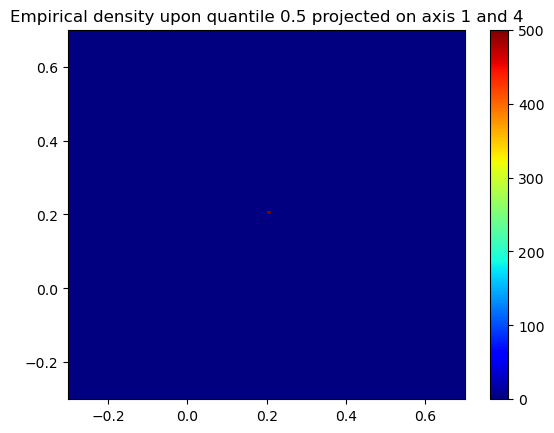

<Figure size 640x480 with 0 Axes>

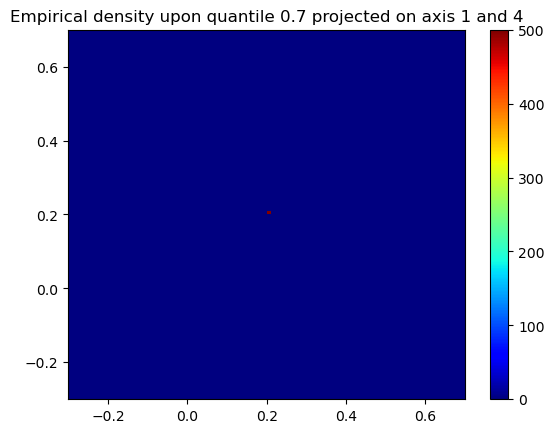

<Figure size 640x480 with 0 Axes>

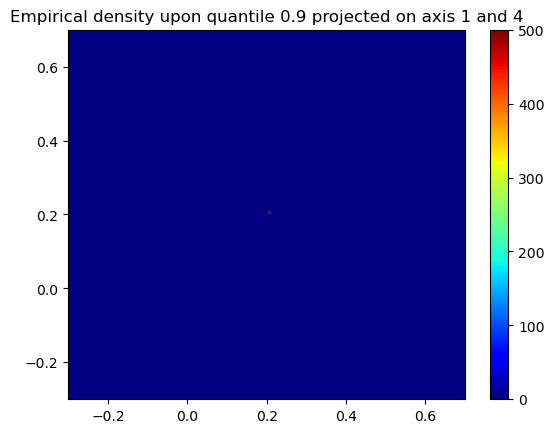

<Figure size 640x480 with 0 Axes>

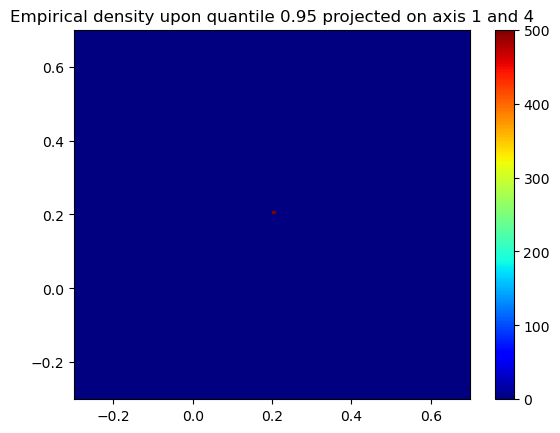

<Figure size 640x480 with 0 Axes>

In [11]:
#Limiting distributions of GANs:
N_samples = 10000
R_gen     = tf.reduce_sum(gen_samples+0.0001,axis = 1)
rmax      = tf.reduce_max(R_gen)
angle_gen = (gen_samples+0.0001)/tf.reshape(R_gen,(N_samples,1))

q_test    = [0.5 ,0.7, 0.9, 0.95]

x1        = 0
x2        = 3

for q in q_test:
    r         = tf.sort(R_gen)[int(q*N_samples)].numpy()
    print(r)
    Ind       = tf.argsort(R_gen).numpy()
    print(Ind)
    angles    = angle_gen.numpy()[Ind[(int(q*N_samples)-250):(int(q*N_samples)+250)]]
    angles_x1 = angles[:,x1]
    print(angles_x1.shape)
    angles_x2 = angles[:,x2]
    print(angles_x2.shape)
    plt.figure()
    plt.title(f'Empirical density upon quantile {q} projected on axis {x1 + 1} and {x2 + 1}')
    h =plt.hist2d(angles_x1, angles_x2,bins=(100, 100), cmap=plt.cm.jet)
    plt.colorbar(h[3])
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    plt.figure()
    '''
    from scipy.stats import kde
    nbins=300
    k = kde.gaussian_kde([angles_x1,angles_x2])
    xi, yi = np.mgrid[angles_x1.min():angles_x1.max():nbins*1j, angles_x2.min():angles_x2.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    plt.colorbar()
    plt.show()
    '''
    

In [21]:
seed = 0
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [22]:
# Samples from R1
N_samples = 10000
A = 2*tfd.Uniform().sample(N_samples)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set = A*X
test_set =test_set.numpy()

In [61]:
print(tf.reduce_max(tfd.Pareto(concentration =1.5, scale=1).sample([batch_size, z_dim])))
      

tf.Tensor(102.955505, shape=(), dtype=float32)


In [15]:
%matplotlib inline
from numpy import expand_dims, mean, ones

from numpy.random import randn, randint
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ModuleNotFoundError: No module named 'keras'

In [4]:
from numpy import expand_dims, mean, ones

from numpy.random import randn, randint
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

In [6]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)
 
# define the standalone critic model
def define_critic(in_shape=(5)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.05)
	# define model
	model = tfk.models.Sequential([
 tfkl.Dense(10, activation='relu', kernel_constraint=const),
tfkl.Dense(5, activation='relu', kernel_constraint=const),
 tfkl.Dense(1,activation = 'linear')])
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = tfk.models.Sequential([
  tfkl.Dense(10, activation='relu'),
  tfkl.Dense(10, activation='relu'),
  tfkl.Dense(5)])
	return model
 
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	critic.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	X = tf.convert_to_tensor(dataset.numpy()[ix])
	# generate class labels, -1 for 'real'
	y = -tf.ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	x_input = tfd.Pareto(concentration=4.5,
    scale=1.0).sample([n_samples,latent_dim])
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = tf.ones((n_samples, 1))
	return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    print("perf")
    # save the generator model
  # 	filename2 = 'model_%04d.h5' % (step+1)
  # 	g_model.save(filename2)
  # 	print('>Saved: %s and %s' % (filename1, filename2))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.show()
    plt.close()
 

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=16, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
    
    
		if (i+1) % 50 == 0: 
			print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
      
      
		# evaluate the model performance every 'epoch'
		if (i+1) % 100 == 0: # %bat_per_epo
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

In [ ]:
# size of the latent space
latent_dim = 5
# create the critic
#critic = define_critic()
# create the generator
#generator = define_generator(latent_dim)
# create the gan
#gan_model = define_gan(generator, critic)
# train model
train(generator, critic, gan_model, n_train_data, latent_dim)

>50, c1=0.048, c2=-0.066 g=0.069
>100, c1=0.057, c2=-0.064 g=0.069
perf
>150, c1=0.054, c2=-0.063 g=0.067
>200, c1=0.054, c2=-0.062 g=0.064
perf
>250, c1=0.059, c2=-0.060 g=0.062
>300, c1=0.054, c2=-0.060 g=0.059
perf
>350, c1=0.044, c2=-0.060 g=0.056
>400, c1=0.040, c2=-0.061 g=0.059
perf
>450, c1=0.051, c2=-0.056 g=0.059
>500, c1=0.049, c2=-0.059 g=0.061
perf
>550, c1=0.046, c2=-0.057 g=0.055
>600, c1=0.042, c2=-0.054 g=0.055
perf
>650, c1=0.049, c2=-0.056 g=0.058
>700, c1=0.041, c2=-0.053 g=0.057
perf
>750, c1=0.036, c2=-0.053 g=0.055
>800, c1=0.044, c2=-0.053 g=0.053
perf
>850, c1=0.039, c2=-0.053 g=0.056
>900, c1=0.043, c2=-0.052 g=0.055
perf
>950, c1=0.046, c2=-0.053 g=0.053
>1000, c1=0.041, c2=-0.051 g=0.050
perf
>1050, c1=0.040, c2=-0.052 g=0.047
>1100, c1=0.048, c2=-0.051 g=0.053
perf
>1150, c1=0.046, c2=-0.050 g=0.054
>1200, c1=0.040, c2=-0.052 g=0.049
perf
>1250, c1=0.046, c2=-0.050 g=0.053
>1300, c1=0.042, c2=-0.052 g=0.047
perf
>1350, c1=0.049, c2=-0.051 g=0.054
>1400, c1=

In [13]:
N_samples = 18244
z_gen = tfd.Pareto(concentration =4.5, scale=1).sample([N_samples,5])
z     = z_gen
gen_samples = generator(z)
print(gen_samples)

print(gen_samples)


tf.Tensor(
[[0.40054315 0.16265531 0.3292271  0.3286661  0.23374595]
 [0.29903626 0.19077809 0.29239857 0.00368873 0.04497734]
 [0.37850606 0.2029507  0.349822   0.32882425 0.2617416 ]
 ...
 [0.24224547 0.20328504 0.2062523  0.03195173 0.04692465]
 [0.37601614 0.15618078 0.2611254  0.3998574  0.24949239]
 [0.3971334  0.1947047  0.39811262 0.22488575 0.20972392]], shape=(18244, 5), dtype=float32)
tf.Tensor(
[[0.40054315 0.16265531 0.3292271  0.3286661  0.23374595]
 [0.29903626 0.19077809 0.29239857 0.00368873 0.04497734]
 [0.37850606 0.2029507  0.349822   0.32882425 0.2617416 ]
 ...
 [0.24224547 0.20328504 0.2062523  0.03195173 0.04692465]
 [0.37601614 0.15618078 0.2611254  0.3998574  0.24949239]
 [0.3971334  0.1947047  0.39811262 0.22488575 0.20972392]], shape=(18244, 5), dtype=float32)


0.6522327
[32462 99935 82780 ... 64915 14247 46758]
(500,)
(500,)


/tmp/ipykernel_31285/293202009.py:32: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([angles_x1,angles_x2])


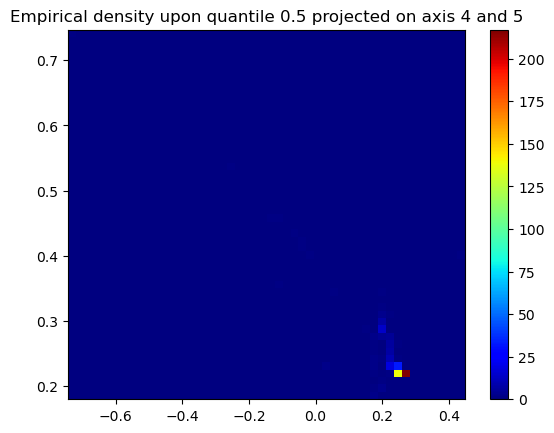

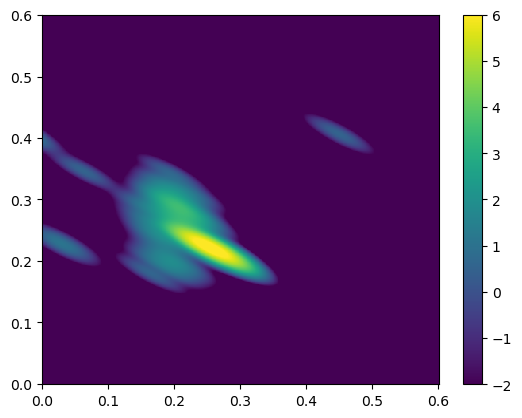

0.81243485
[32462 99935 82780 ... 64915 14247 46758]
(500,)
(500,)


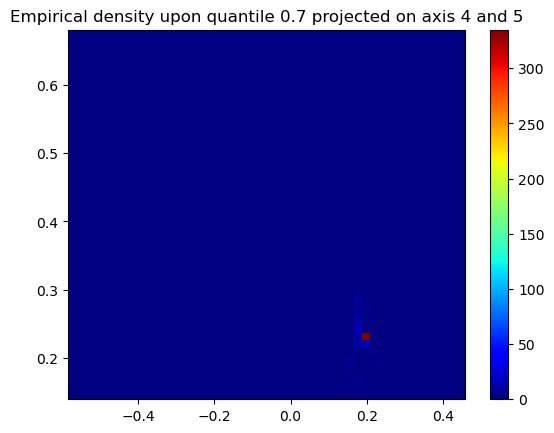

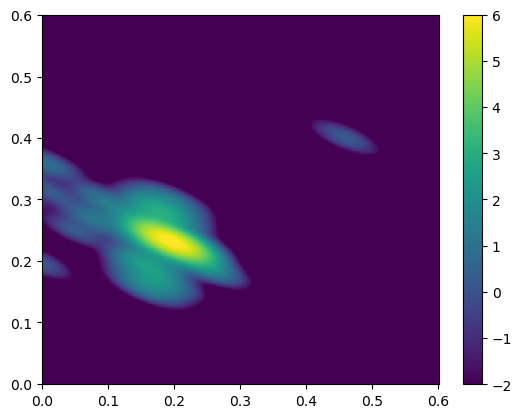

1.8101879
[32462 99935 82780 ... 64915 14247 46758]
(500,)
(500,)


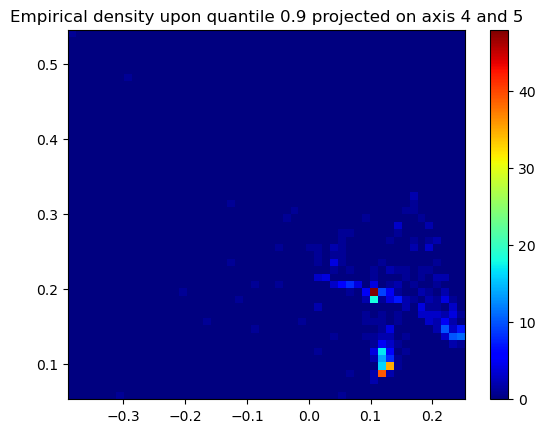

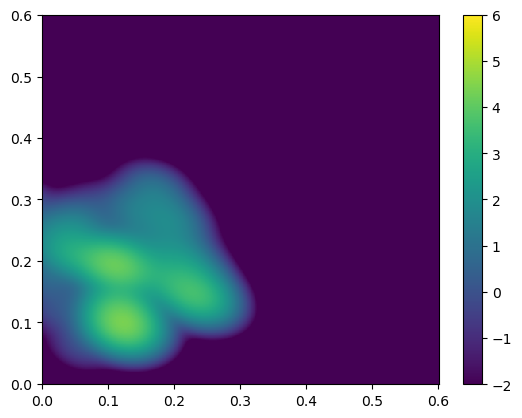

20.081789
[32462 99935 82780 ... 64915 14247 46758]
(500,)
(500,)


/tmp/ipykernel_31285/293202009.py:34: RuntimeWarning: divide by zero encountered in log
  zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))


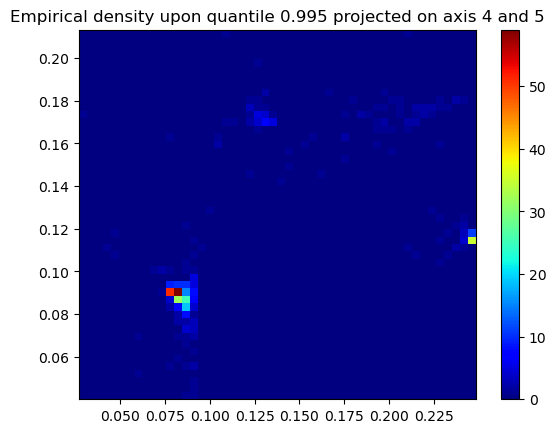

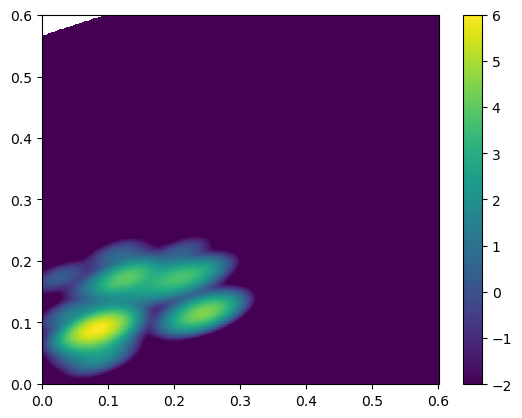

In [75]:
#Limiting distributions of GANs:
from matplotlib.colors import Normalize
N_samples = 100000
R_gen     = tf.reduce_sum(gen_samples+0.0001,axis = 1)
rmax      = tf.reduce_max(R_gen)
angle_gen = (gen_samples+0.0001)/tf.reshape(R_gen,(N_samples,1))

q_test    = [0.5 ,0.7, 0.9, 0.995]

x1        = 3
x2        = 4

for q in q_test:
    r         = tf.sort(R_gen)[int(q*N_samples)].numpy()
    print(r)
    Ind       = tf.argsort(R_gen).numpy()
    print(Ind)
    angles    = angle_gen.numpy()[Ind[(int(q*N_samples)):(int(q*N_samples)+500)]]
    angles_x1 = angles[:,x1]
    print(angles_x1.shape)
    angles_x2 = angles[:,x2]
    print(angles_x2.shape)
    plt.figure()
    plt.title(f'Empirical density upon quantile {q} projected on axis {x1 + 1} and {x2 + 1}')
    h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
    plt.colorbar(h[3])
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    plt.figure()

    from scipy.stats import kde
    nbins=500
    k = kde.gaussian_kde([angles_x1,angles_x2])
    xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
    zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))
 
    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto',norm=Normalize(vmin=-2,vmax=6))
    plt.colorbar()
    plt.show()

    

In [13]:
filename ='/home/nlafon/These/Extreme_VAE/tmp/Exp1/GANDanube/checkpoint'
#generator.save_weights(filename)

In [14]:
gen2 = define_generator(5)
gen2.load_weights(filename)

2023-01-19 10:31:23.907073: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-19 10:31:23.909721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-19 10:31:24.012973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2023-01-19 10:31:24.013225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:73:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2023-01-19 10:31:24.013266: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-19 

In [23]:
def alphas_function(x):
    res = tf.convert_to_tensor([6. -3.*tf.minimum(1.,0.5/x), 6. -3.*tf.minimum(1.,0.5/x) , 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x)])
    return(tf.transpose(res))


alphas          = alphas_function(test_set)
angle_train_dep = tfd.Dirichlet(alphas).sample()
real_samples    = angle_train_dep*tf.reshape(test_set,(10000,1))

In [12]:
gen_samples = gen2(tfd.Pareto(concentration =4.5, scale=1).sample([18244,5]))
print(gen_samples)

NameError: name 'gen2' is not defined

In [25]:
import ot
def Wasserstein(s1,s2):
    M        = ot.dist(s1,s2)
    n1, n2   = s1.shape[0],s2.shape[0]
    a, b     = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    return(ot.emd2(a,b,M))

In [44]:
#Optimal transport upon threshold
Ind_true       = tf.argsort(test_set)
ordered_true   = real_samples.numpy()[Ind_true]
Ind_gen        = tf.argsort(tf.reduce_sum(tf.abs(gen_samples),axis = 1))
ordered_gen    = gen_samples.numpy()[Ind_gen]
print(ordered_gen.shape)

(10000, 5)


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

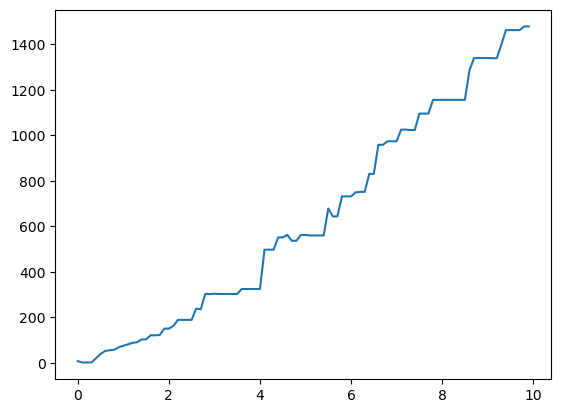

In [45]:
rad    = []
res    = []
r0     = 0
rmax   = 10

n_step = 100
step   = (rmax-r0)/n_step
r_curr = r0

for i in range(n_step):
    ind1     = np.where(ordered_true > r_curr)[0][0]
    ind2     = np.where(ordered_gen  > r_curr)[0][0]
    true_sup = ordered_true[ind1:,:]
    gen_sup  = ordered_gen[ind2:,:]
    res.append(Wasserstein(gen_sup,true_sup))
    rad.append(r_curr)
    r_curr  += step 
    
plt.plot(rad,res)

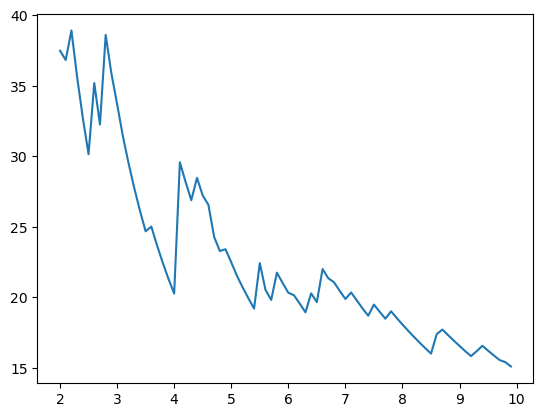

In [46]:
res2 = np.array(res[20:])/(np.array(rad[20:])**2)
r2 = np.array(rad[20:])
plt.plot(r2,res2)

In [47]:
Wasserstein(gen_samples.numpy(),real_samples.numpy())

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


6.803093657640285

In [30]:
Y= [23.70003105, 27.46059746, 25.02091628, 25.82019021, 23.71333442, 21.854209,
 24.97652626, 23.16067456, 23.68815072, 22.08265181, 29.40781961, 29.20982586,
 27.69786343, 26.06518961, 24.5544909,  23.17142162, 21.9019996,  20.73410627,
 25.11557241, 23.84410688, 22.6668041,  21.57459046, 20.5594595,  20.482639,
 19.56218983, 18.70241951, 29.60394933, 28.35760832, 27.1883493,  26.08994452,
 26.46452405, 25.43687433, 24.46794013, 23.55333219, 22.68906383, 21.87150748,
 25.52637772, 24.69361087, 23.8494476,  23.04784307, 22.48155087, 21.90523234,
 21.2043105,  20.91595767, 27.37485844, 26.53903436, 25.74091372, 25.11783692,
 24.38450907, 23.68283343, 23.01101427, 22.36738146, 21.75038001, 21.1585607,
 21.59069989, 21.01878624, 20.46929928, 20.17766826, 19.66360867, 19.1689465,
 18.69271799, 18.23401846, 17.79199808, 17.36585791, 16.95484625, 16.55825538,
 16.17541849, 15.80570685, 15.44852726, 15.10331967, 14.96654404, 16.81555651,
 16.45198765, 16.10008364, 15.75935077, 15.42932116, 15.10955115, 14.79961988,
 14.94359164, 14.6432256, ]

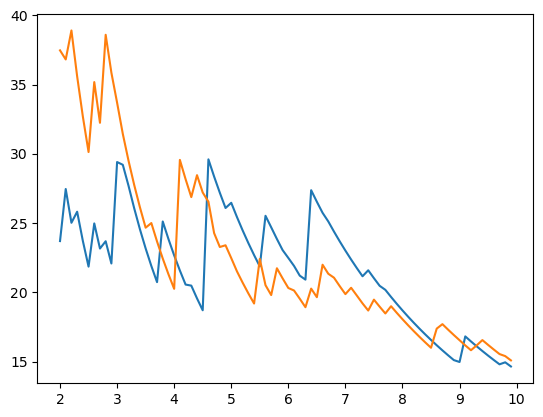

In [48]:
plt.plot(r2,Y)
plt.plot(r2,res2)

In [36]:
R      = tf.reduce_sum(tf.abs(gen_samples),axis=1)
angles = gen_samples/tf.reshape(R,(10000,1))

In [40]:
Ind       = tf.argsort(R)
R1_sort   = R.numpy()[Ind]
angle_dep = angles.numpy()[Ind]

In [41]:
def distmat(X):
    r = tf.reduce_sum(X*X, 1)
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(X, tf.transpose(X)) + tf.transpose(r)
    return(tf.maximum(D,0))

def T(X,Y,n):
    MX = tf.math.sqrt(distmat(X))
    MY = tf.math.sqrt(distmat(Y))
    T1 = (1/n**2)*tf.reduce_sum(tf.math.multiply(MX,MY))
    T2 = (2/n**3)*tf.reduce_sum(tf.linalg.matmul(MX,MY))
    T3 = (1/n**4)*tf.reduce_sum(tf.tensordot(MX,MY,axes=0))
    return T1-T2+T3


In [43]:
nbq = 100
qmax=0.01
qmin=0.3
m=60
L=200

qk = np.arange(qmax,qmin,(qmin-qmax+0.001)/nbq)
nk = 500*qk
res=[]

for i in range(nbq):
    print(i)
    pvi = 0
    q = qk[i]
    indq =int((1-q)*10000)
    n = int(nk[i])
    r = R1_sort[indq]
    print(r)
    print(q)
    Rq = R1_sort[indq:]/r
    angle = angle_dep[indq:]
    Nq = 10000-indq
    for k in range(m):
        IndS = tf.random.shuffle(tf.range(start=0, limit=Nq, dtype=tf.int32))[:n]
        RqS_joint = tf.gather(Rq,IndS)
        RqS_joint = tf.reshape(RqS_joint,(n,1))
        angleS_joint = tf.gather(angle,IndS)
        T_emp = T(RqS_joint,angleS_joint,int(n))
        pvk=0
        for j in range(L):
            RqS_ind=tf.random.shuffle(Rq)[:int(n)]
            RqS_ind = tf.reshape(RqS_ind,(n,1))
            angleS_ind = tf.random.shuffle(angle)[:int(n)]
            T_ind = T(RqS_ind,angleS_ind,int(n))
            pvk+= T_emp.numpy()<(T_ind.numpy())
        pvk = pvk/L
        pvi+=pvk
    pvi = pvi/m
    res.append(pvi)
    print(qk[i])
    print(pvi)

0
14.462597
0.01
0.01
0.5419999999999999
1
12.0251045
0.01291
0.01291
0.4516666666666666
2
9.357689
0.01582
0.01582
0.4552499999999999
3
8.045995
0.018729999999999997
0.018729999999999997
0.5132500000000001
4
7.448904
0.02164
0.02164
0.4848333333333332
5
6.751164
0.024549999999999995
0.024549999999999995
0.5123333333333334
6
5.9981446
0.02746
0.02746
0.5370833333333332
7
5.556053
0.030369999999999994
0.030369999999999994
0.4942499999999998
8
5.0830154
0.03328
0.03328
0.5068333333333332
9
4.7592773
0.03618999999999999
0.03618999999999999
0.5777500000000001
10
4.4701777
0.039099999999999996
0.039099999999999996
0.4358333333333333
11
4.1648436
0.04201
0.04201
0.4629166666666668
12
3.9208143
0.044919999999999995
0.044919999999999995
0.5274999999999999
13
3.701698
0.04782999999999999
0.04782999999999999
0.5010833333333334
14
3.5690541
0.05073999999999999
0.05073999999999999
0.4765
15
3.4248142
0.053649999999999996
0.053649999999999996
0.5103333333333334
16
3.2515962
0.05655999999999999
0.05

2022-12-01 12:43:59.256804: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 60.09MiB (rounded to 63012096)requested by op MatMul
Current allocation summary follows.
2022-12-01 12:43:59.256961: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2022-12-01 12:43:59.257030: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 144, Chunks in use: 143. 36.0KiB allocated for chunks. 35.8KiB in use in bin. 1.8KiB client-requested in use in bin.
2022-12-01 12:43:59.257076: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 400B client-requested in use in bin.
2022-12-01 12:43:59.257123: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 2, Chunks in use: 2. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 2.2KiB client-requested in use i

ResourceExhaustedError: OOM when allocating tensor with shape[3969,3969] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

In [51]:
print(tf.sort(test_set)[9900])

tf.Tensor(11.923685, shape=(), dtype=float32)


In [15]:
R4 = dataset[:,22:27]
R4_23 = np.sort(R4[:,0])
R4_24 = np.sort(R4[:,1])
R4_25 = np.sort(R4[:,2])
R4_26 = np.sort(R4[:,3])
R4_27 = np.sort(R4[:,4])

q = 0.9
n = int(q*18244)

print(R4_23[n])
print(R4_24[n])
print(R4_25[n])
print(R4_26[n])
print(R4_27[n])

U1 = R4[:,0]>R4_23[n]
U2 = R4[:,1]>R4_24[n]
U3 = R4[:,2]>R4_25[n]
U4 = R4[:,3]>R4_26[n]
U5 = R4[:,4]>R4_27[n]
print(np.sum(U1)/18244)
print(np.sum(U1*U2)/18244)
print(np.sum(U1*U2*U3)/18244)
print(np.sum(U1*U2*U3*U4)/18244)
print(np.sum(U1*U2*U3*U4*U5)/18244)
#print(np.count_nonzero(R4[:,0]>R4_23[n] & R4[:,1]>R4_24[n]))


96.5
78.6
69.0
62.1
47.6
0.09981363736022802
0.09531900898925674
0.06643279982459988
0.05985529489147117
0.05064678798509099


In [16]:
#Generated samples
genD = 100*gen_samples.numpy()


print(R4_23[n])
print(R4_24[n])
print(R4_25[n])
print(R4_26[n])
print(R4_27[n])

U1 = genD[:,0]>R4_23[n]
U2 = genD[:,1]>R4_24[n]
U3 = genD[:,2]>R4_25[n]
U4 = genD[:,3]>R4_26[n]
U5 = genD[:,4]>R4_27[n]

print(np.sum(U1)/18244)
print(np.sum(U1*U2)/18244)
print(np.sum(U1*U2*U3)/18244)
print(np.sum(U1*U2*U3*U4)/18244)
print(np.sum(U1*U2*U3*U4*U5)/18244)
#print(np.count_nonzero(R4[:,0]>R4_23[n] & R4[:,1]>R4_24[n]))

96.5
78.6
69.0
62.1
47.6
0.009701819776364832
0.0
0.0
0.0
0.0


In [14]:
print(2/18244)

0.00010962508221881167
